# Train a model with Classical Training
https://github.com/sicara/easy-few-shot-learning/blob/master/notebooks/classical_training.ipynb

In [1]:
try:
    import google.colab
    colab = True
except:
    colab = False

In [2]:
if colab is True:
    # Running in Google Colab
    # Clone the repo
    !git clone https://github.com/sicara/easy-few-shot-learning
    %cd easy-few-shot-learning
    !pip install .
else:
    # Run locally
    # Ensure working directory is the project's root
    # Make sure easyfsl is installed!
    %cd ..


Cloning into 'easy-few-shot-learning'...
remote: Enumerating objects: 1201, done.
remote: Counting objects: 100% (364/364), done.
remote: Compressing objects: 100% (186/186), done.
remote: Total 1201 (delta 255), reused 182 (delta 178), pack-reused 837 (from 1)
Receiving objects: 100% (1201/1201), 2.31 MiB | 23.42 MiB/s, done.
Resolving deltas: 100% (723/723), done.
/content/easy-few-shot-learning
Processing /content/easy-few-shot-learning
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 87.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━

In [3]:
import copy
from pathlib import Path
import random
from statistics import mean

import numpy as np
import torch
from torch import nn
from tqdm import tqdm

In [4]:
random_seed = 0
np.random.seed(random_seed)
torch.manual_seed(random_seed)
random.seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
!pip install gdown

In [6]:
# Download the CUB dataset
!make download-cub

mkdir -p data/CUB
wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=.*/\1\n/p')&id=1GDr1OkoXdhaXWGA8S3MAq3a522Tak-nx" -O data/CUB/images.tgz
Cannot open cookies file ‘/tmp/cookies.txt’: No such file or directory
--2025-02-02 06:25:59--  https://docs.google.com/uc?export=download&confirm=.*/%5C1%5Cn/p')&id=1GDr1OkoXdhaXWGA8S3MAq3a522Tak-nx
Resolving docs.google.com (docs.google.com)... 172.253.117.139, 172.253.117.100, 172.253.117.138, ...
Connecting to docs.google.com (docs.google.com)|172.253.117.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1GDr1OkoXdhaXWGA8S3MAq3a522Tak-nx&export=download [following]
--2025-02-02 06:25:59--  https://drive.usercontent.google.com/download?id=1GDr1OkoXdhaXWGA8S3MAq3a522Tak-nx&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.142.132, 2607:f8b0:400e:c0a::84
Connecting to drive.user

要手動上傳資料上去，因為 colab 檔住大量資料下載

https://github.com/sicara/easy-few-shot-learning/issues/161

In [7]:
! cp /content/drive/MyDrive/Code/FewShot/data/images.tgz /content/easy-few-shot-learning/data/CUB

In [8]:
! tar -zxvf data/CUB/images.tgz -C data/CUB/

串流輸出內容已截斷至最後 5000 行。
images/085.Horned_Lark/._Horned_Lark_0026_447529302.jpg
images/085.Horned_Lark/Horned_Lark_0026_447529302.jpg
images/085.Horned_Lark/._Horned_Lark_0027_2871921401.jpg
images/085.Horned_Lark/Horned_Lark_0027_2871921401.jpg
images/085.Horned_Lark/._Horned_Lark_0028_749325298.jpg
images/085.Horned_Lark/Horned_Lark_0028_749325298.jpg
images/085.Horned_Lark/._Horned_Lark_0029_2283904413.jpg
images/085.Horned_Lark/Horned_Lark_0029_2283904413.jpg
images/085.Horned_Lark/._Horned_Lark_0030_390266927.jpg
images/085.Horned_Lark/Horned_Lark_0030_390266927.jpg
images/085.Horned_Lark/._Horned_Lark_0031_2376117616.jpg
images/085.Horned_Lark/Horned_Lark_0031_2376117616.jpg
images/085.Horned_Lark/._Horned_Lark_0032_2297336214.jpg
images/085.Horned_Lark/Horned_Lark_0032_2297336214.jpg
images/084.Red_legged_Kittiwake/._Red_legged_Kittiwake_0001_2255271983.jpg
images/084.Red_legged_Kittiwake/Red_legged_Kittiwake_0001_2255271983.jpg
images/084.Red_legged_Kittiwake/._Red_legged_Kittiwak

In [9]:
import os
import glob

pattern = '/content/easy-few-shot-learning/data/CUB/images/*/._*.jpg'
files_to_delete = glob.glob(pattern)
for file_path in files_to_delete:
    os.remove(file_path)
    print(f"Deleted file: {file_path}")


串流輸出內容已截斷至最後 5000 行。
Deleted file: /content/easy-few-shot-learning/data/CUB/images/150.Sage_Thrasher/._Sage_Thrasher_0018_161319569.jpg
Deleted file: /content/easy-few-shot-learning/data/CUB/images/150.Sage_Thrasher/._Sage_Thrasher_0013_502651409.jpg
Deleted file: /content/easy-few-shot-learning/data/CUB/images/150.Sage_Thrasher/._Sage_Thrasher_0002_2532542571.jpg
Deleted file: /content/easy-few-shot-learning/data/CUB/images/150.Sage_Thrasher/._Sage_Thrasher_0025_2291713227.jpg
Deleted file: /content/easy-few-shot-learning/data/CUB/images/150.Sage_Thrasher/._Sage_Thrasher_0007_2520508677.jpg
Deleted file: /content/easy-few-shot-learning/data/CUB/images/150.Sage_Thrasher/._Sage_Thrasher_0020_1516672927.jpg
Deleted file: /content/easy-few-shot-learning/data/CUB/images/150.Sage_Thrasher/._Sage_Thrasher_0027_2701048732.jpg
Deleted file: /content/easy-few-shot-learning/data/CUB/images/150.Sage_Thrasher/._Sage_Thrasher_0014_418817495.jpg
Deleted file: /content/easy-few-shot-learning/data/CUB

In [10]:
pattern = '/content/easy-few-shot-learning/data/CUB/images/*/*.jpg'
files = glob.glob(pattern)
len(files)

6033

In [11]:
from easyfsl.datasets import CUB
from torch.utils.data import DataLoader

batch_size = 128
n_workers = 2

train_set = CUB(split="train", training=True)
train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    num_workers=n_workers,
    pin_memory=True,
    shuffle=True,
)

In [12]:
len(train_set)

4258

In [13]:
from easyfsl.modules import resnet12

DEVICE = "cuda"

model = resnet12(
    use_fc=True,
    num_classes=len(set(train_set.get_labels())),
).to(DEVICE)

In [14]:
from easyfsl.methods import PrototypicalNetworks
from easyfsl.samplers import TaskSampler

n_way = 3
n_shot = 5
n_query = 10
n_validation_tasks = 50

val_set = CUB(split="val", training=False)
val_sampler = TaskSampler(
    val_set, n_way=n_way, n_shot=n_shot, n_query=n_query, n_tasks=n_validation_tasks
)
val_loader = DataLoader(
    val_set,
    batch_sampler=val_sampler,
    num_workers=n_workers,
    pin_memory=True,
    collate_fn=val_sampler.episodic_collate_fn,
)

few_shot_classifier = PrototypicalNetworks(model).to(DEVICE)

# Training

In [21]:
from torch.optim import SGD, Optimizer
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter


LOSS_FUNCTION = nn.CrossEntropyLoss()

n_epochs = 100
scheduler_milestones = [150, 180]
scheduler_gamma = 0.1
learning_rate = 1e-01
tb_logs_dir = Path(".")

train_optimizer = SGD(
    model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4
)
train_scheduler = MultiStepLR(
    train_optimizer,
    milestones=scheduler_milestones,
    gamma=scheduler_gamma,
)

tb_writer = SummaryWriter(log_dir=str(tb_logs_dir))

In [22]:
def training_epoch(model_: nn.Module, data_loader: DataLoader, optimizer: Optimizer):
    all_loss = []
    model_.train()
    with tqdm(data_loader, total=len(data_loader), desc="Training") as tqdm_train:
        for images, labels in tqdm_train:
            optimizer.zero_grad()

            loss = LOSS_FUNCTION(model_(images.to(DEVICE)), labels.to(DEVICE))
            loss.backward()
            optimizer.step()

            all_loss.append(loss.item())

            tqdm_train.set_postfix(loss=mean(all_loss))

    return mean(all_loss)

In [23]:
# from easyfsl.utils import evaluate


# best_state = model.state_dict()
# best_validation_accuracy = 0.0
# validation_frequency = 10
# for epoch in range(n_epochs):
#     print(f"Epoch {epoch}")
#     average_loss = training_epoch(model, train_loader, train_optimizer)

#     if epoch % validation_frequency == validation_frequency - 1:

#         # We use this very convenient method from EasyFSL's ResNet to specify
#         # that the model shouldn't use its last fully connected layer during validation.
#         model.set_use_fc(False)
#         validation_accuracy = evaluate(
#             few_shot_classifier, val_loader, device=DEVICE, tqdm_prefix="Validation"
#         )
#         model.set_use_fc(True)

#         if validation_accuracy > best_validation_accuracy:
#             best_validation_accuracy = validation_accuracy
#             best_state = copy.deepcopy(few_shot_classifier.state_dict())
#             # state_dict() returns a reference to the still evolving model's state so we deepcopy
#             # https://pytorch.org/tutorials/beginner/saving_loading_models
#             print("Ding ding ding! We found a new best model!")

#         tb_writer.add_scalar("Val/acc", validation_accuracy, epoch)

#     tb_writer.add_scalar("Train/loss", average_loss, epoch)

#     # Warn the scheduler that we did an epoch
#     # so it knows when to decrease the learning rate
#     train_scheduler.step()

In [24]:
from easyfsl.utils import evaluate
# 保存最優模型狀態
best_state = None
best_validation_accuracy = 0.0
validation_frequency = 10

for epoch in range(n_epochs):
    print(f"Epoch {epoch}")
    average_loss = training_epoch(model, train_loader, train_optimizer)

    if epoch % validation_frequency == validation_frequency - 1:
        model.set_use_fc(False)
        validation_accuracy = evaluate(
            few_shot_classifier, val_loader, device=DEVICE, tqdm_prefix="Validation"
        )
        model.set_use_fc(True)

        # 更新最優模型狀態
        if validation_accuracy > best_validation_accuracy:
            best_validation_accuracy = validation_accuracy
            best_state = copy.deepcopy(few_shot_classifier.state_dict())
            print("Ding ding ding! We found a new best model!")

        tb_writer.add_scalar("Val/acc", validation_accuracy, epoch)

    tb_writer.add_scalar("Train/loss", average_loss, epoch)

    train_scheduler.step()

# 加載最優模型狀態
if best_state is not None:
    few_shot_classifier.load_state_dict(best_state)
    print("Loaded the best model state!")
else:
    print("No best state was saved.")


Epoch 0


Training: 100%|██████████| 34/34 [00:29<00:00,  1.14it/s, loss=6.19]


Epoch 1


Training: 100%|██████████| 34/34 [00:27<00:00,  1.23it/s, loss=5.55]


Epoch 2


Training: 100%|██████████| 34/34 [00:25<00:00,  1.32it/s, loss=5.28]


Epoch 3


Training: 100%|██████████| 34/34 [00:28<00:00,  1.20it/s, loss=5.14]


Epoch 4


Training: 100%|██████████| 34/34 [00:26<00:00,  1.28it/s, loss=4.98]


Epoch 5


Training: 100%|██████████| 34/34 [00:26<00:00,  1.29it/s, loss=4.89]


Epoch 6


Training: 100%|██████████| 34/34 [00:27<00:00,  1.24it/s, loss=4.77]


Epoch 7


Training: 100%|██████████| 34/34 [00:26<00:00,  1.30it/s, loss=4.68]


Epoch 8


Training: 100%|██████████| 34/34 [00:27<00:00,  1.23it/s, loss=4.6]


Epoch 9


Validation: 100%|██████████| 50/50 [00:08<00:00,  5.98it/s, accuracy=0.624]


Ding ding ding! We found a new best model!
Epoch 10


Training: 100%|██████████| 34/34 [00:27<00:00,  1.24it/s, loss=5.2]


Epoch 11


Training: 100%|██████████| 34/34 [00:26<00:00,  1.30it/s, loss=4.8]


Epoch 12


Training: 100%|██████████| 34/34 [00:27<00:00,  1.25it/s, loss=4.4]


Epoch 13


Training: 100%|██████████| 34/34 [00:26<00:00,  1.29it/s, loss=4.21]


Epoch 14


Training: 100%|██████████| 34/34 [00:26<00:00,  1.30it/s, loss=4.12]


Epoch 15


Training: 100%|██████████| 34/34 [00:27<00:00,  1.23it/s, loss=4.04]


Epoch 16


Training: 100%|██████████| 34/34 [00:26<00:00,  1.28it/s, loss=4.03]


Epoch 17


Training: 100%|██████████| 34/34 [00:27<00:00,  1.23it/s, loss=3.93]


Epoch 18


Training: 100%|██████████| 34/34 [00:27<00:00,  1.25it/s, loss=3.88]


Epoch 19


Validation: 100%|██████████| 50/50 [00:10<00:00,  4.73it/s, accuracy=0.655]


Ding ding ding! We found a new best model!
Epoch 20


Training: 100%|██████████| 34/34 [00:26<00:00,  1.29it/s, loss=3.78]


Epoch 21


Training: 100%|██████████| 34/34 [00:26<00:00,  1.26it/s, loss=3.69]


Epoch 22


Training: 100%|██████████| 34/34 [00:26<00:00,  1.27it/s, loss=3.72]


Epoch 23


Training: 100%|██████████| 34/34 [00:25<00:00,  1.31it/s, loss=3.66]


Epoch 24


Training: 100%|██████████| 34/34 [00:27<00:00,  1.22it/s, loss=3.59]


Epoch 25


Training: 100%|██████████| 34/34 [00:26<00:00,  1.29it/s, loss=3.57]


Epoch 26


Training: 100%|██████████| 34/34 [00:26<00:00,  1.31it/s, loss=3.5]


Epoch 27


Training: 100%|██████████| 34/34 [00:27<00:00,  1.22it/s, loss=3.42]


Epoch 28


Training: 100%|██████████| 34/34 [00:26<00:00,  1.29it/s, loss=3.42]


Epoch 29


Validation: 100%|██████████| 50/50 [00:10<00:00,  4.76it/s, accuracy=0.735]


Ding ding ding! We found a new best model!
Epoch 30


Training: 100%|██████████| 34/34 [00:25<00:00,  1.31it/s, loss=3.32]


Epoch 31


Training: 100%|██████████| 34/34 [00:27<00:00,  1.24it/s, loss=3.23]


Epoch 32


Training: 100%|██████████| 34/34 [00:25<00:00,  1.31it/s, loss=3.25]


Epoch 33


Training: 100%|██████████| 34/34 [00:26<00:00,  1.31it/s, loss=3.15]


Epoch 34


Training: 100%|██████████| 34/34 [00:27<00:00,  1.24it/s, loss=3.09]


Epoch 35


Training: 100%|██████████| 34/34 [00:26<00:00,  1.30it/s, loss=3.05]


Epoch 36


Training: 100%|██████████| 34/34 [00:26<00:00,  1.27it/s, loss=3]


Epoch 37


Training: 100%|██████████| 34/34 [00:26<00:00,  1.27it/s, loss=2.95]


Epoch 38


Training: 100%|██████████| 34/34 [00:26<00:00,  1.30it/s, loss=2.89]


Epoch 39


Validation: 100%|██████████| 50/50 [00:09<00:00,  5.46it/s, accuracy=0.732]


Epoch 40


Training: 100%|██████████| 34/34 [00:27<00:00,  1.26it/s, loss=2.82]


Epoch 41


Training: 100%|██████████| 34/34 [00:26<00:00,  1.28it/s, loss=2.83]


Epoch 42


Training: 100%|██████████| 34/34 [00:26<00:00,  1.30it/s, loss=2.75]


Epoch 43


Training: 100%|██████████| 34/34 [00:27<00:00,  1.24it/s, loss=2.72]


Epoch 44


Training: 100%|██████████| 34/34 [00:26<00:00,  1.30it/s, loss=2.66]


Epoch 45


Training: 100%|██████████| 34/34 [00:27<00:00,  1.24it/s, loss=2.61]


Epoch 46


Training: 100%|██████████| 34/34 [00:26<00:00,  1.27it/s, loss=2.54]


Epoch 47


Training: 100%|██████████| 34/34 [00:26<00:00,  1.30it/s, loss=2.53]


Epoch 48


Training: 100%|██████████| 34/34 [00:27<00:00,  1.23it/s, loss=2.48]


Epoch 49


Validation: 100%|██████████| 50/50 [00:10<00:00,  4.83it/s, accuracy=0.781]


Ding ding ding! We found a new best model!
Epoch 50


Training: 100%|██████████| 34/34 [00:26<00:00,  1.27it/s, loss=2.43]


Epoch 51


Training: 100%|██████████| 34/34 [00:25<00:00,  1.31it/s, loss=2.36]


Epoch 52


Training: 100%|██████████| 34/34 [00:26<00:00,  1.26it/s, loss=2.33]


Epoch 53


Training: 100%|██████████| 34/34 [00:25<00:00,  1.32it/s, loss=2.29]


Epoch 54


Training: 100%|██████████| 34/34 [00:26<00:00,  1.29it/s, loss=2.24]


Epoch 55


Training: 100%|██████████| 34/34 [00:26<00:00,  1.27it/s, loss=2.18]


Epoch 56


Training: 100%|██████████| 34/34 [00:25<00:00,  1.32it/s, loss=2.21]


Epoch 57


Training: 100%|██████████| 34/34 [00:27<00:00,  1.25it/s, loss=2.15]


Epoch 58


Training: 100%|██████████| 34/34 [00:26<00:00,  1.28it/s, loss=2.18]


Epoch 59


Validation: 100%|██████████| 50/50 [00:10<00:00,  4.55it/s, accuracy=0.779]


Epoch 60


Training: 100%|██████████| 34/34 [00:25<00:00,  1.32it/s, loss=2.05]


Epoch 61


Training: 100%|██████████| 34/34 [00:26<00:00,  1.26it/s, loss=1.92]


Epoch 62


Training: 100%|██████████| 34/34 [00:26<00:00,  1.28it/s, loss=1.94]


Epoch 63


Training: 100%|██████████| 34/34 [00:25<00:00,  1.34it/s, loss=1.98]


Epoch 64


Training: 100%|██████████| 34/34 [00:27<00:00,  1.26it/s, loss=1.87]


Epoch 65


Training: 100%|██████████| 34/34 [00:25<00:00,  1.32it/s, loss=1.87]


Epoch 66


Training: 100%|██████████| 34/34 [00:26<00:00,  1.28it/s, loss=1.93]


Epoch 67


Training: 100%|██████████| 34/34 [00:25<00:00,  1.32it/s, loss=1.85]


Epoch 68


Training: 100%|██████████| 34/34 [00:26<00:00,  1.30it/s, loss=1.76]


Epoch 69


Validation: 100%|██████████| 50/50 [00:09<00:00,  5.42it/s, accuracy=0.814]


Ding ding ding! We found a new best model!
Epoch 70


Training: 100%|██████████| 34/34 [00:27<00:00,  1.25it/s, loss=1.78]


Epoch 71


Training: 100%|██████████| 34/34 [00:27<00:00,  1.26it/s, loss=1.79]


Epoch 72


Training: 100%|██████████| 34/34 [00:25<00:00,  1.31it/s, loss=1.69]


Epoch 73


Training: 100%|██████████| 34/34 [00:27<00:00,  1.25it/s, loss=1.63]


Epoch 74


Training: 100%|██████████| 34/34 [00:25<00:00,  1.32it/s, loss=1.71]


Epoch 75


Training: 100%|██████████| 34/34 [00:27<00:00,  1.24it/s, loss=1.64]


Epoch 76


Training: 100%|██████████| 34/34 [00:26<00:00,  1.28it/s, loss=1.58]


Epoch 77


Training: 100%|██████████| 34/34 [00:25<00:00,  1.31it/s, loss=1.57]


Epoch 78


Training: 100%|██████████| 34/34 [00:27<00:00,  1.23it/s, loss=1.54]


Epoch 79


Validation: 100%|██████████| 50/50 [00:10<00:00,  4.98it/s, accuracy=0.784]


Epoch 80


Training: 100%|██████████| 34/34 [00:26<00:00,  1.27it/s, loss=1.57]


Epoch 81


Training: 100%|██████████| 34/34 [00:26<00:00,  1.30it/s, loss=1.52]


Epoch 82


Training: 100%|██████████| 34/34 [00:27<00:00,  1.24it/s, loss=1.5]


Epoch 83


Training: 100%|██████████| 34/34 [00:26<00:00,  1.31it/s, loss=1.45]


Epoch 84


Training: 100%|██████████| 34/34 [00:26<00:00,  1.27it/s, loss=1.48]


Epoch 85


Training: 100%|██████████| 34/34 [00:26<00:00,  1.30it/s, loss=1.44]


Epoch 86


Training: 100%|██████████| 34/34 [00:25<00:00,  1.32it/s, loss=1.41]


Epoch 87


Training: 100%|██████████| 34/34 [00:27<00:00,  1.23it/s, loss=1.43]


Epoch 88


Training: 100%|██████████| 34/34 [00:25<00:00,  1.31it/s, loss=1.43]


Epoch 89


Validation: 100%|██████████| 50/50 [00:10<00:00,  4.81it/s, accuracy=0.829]


Ding ding ding! We found a new best model!
Epoch 90


Training: 100%|██████████| 34/34 [00:25<00:00,  1.31it/s, loss=1.37]


Epoch 91


Training: 100%|██████████| 34/34 [00:27<00:00,  1.24it/s, loss=1.27]


Epoch 92


Training: 100%|██████████| 34/34 [00:26<00:00,  1.30it/s, loss=1.31]


Epoch 93


Training: 100%|██████████| 34/34 [00:25<00:00,  1.33it/s, loss=1.29]


Epoch 94


Training: 100%|██████████| 34/34 [00:27<00:00,  1.24it/s, loss=1.25]


Epoch 95


Training: 100%|██████████| 34/34 [00:26<00:00,  1.31it/s, loss=1.22]


Epoch 96


Training: 100%|██████████| 34/34 [00:26<00:00,  1.27it/s, loss=1.26]


Epoch 97


Training: 100%|██████████| 34/34 [00:26<00:00,  1.30it/s, loss=1.2]


Epoch 98


Training: 100%|██████████| 34/34 [00:25<00:00,  1.32it/s, loss=1.26]


Epoch 99


Validation: 100%|██████████| 50/50 [00:09<00:00,  5.37it/s, accuracy=0.845]

Ding ding ding! We found a new best model!
Loaded the best model state!


In [25]:
n_test_tasks = 10

test_set = CUB(split="test", training=False)
test_sampler = TaskSampler(
    test_set, n_way=n_way, n_shot=n_shot, n_query=n_query, n_tasks=n_test_tasks
)
test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=n_workers,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

In [26]:
model.set_use_fc(False)

accuracy = evaluate(few_shot_classifier, test_loader, device=DEVICE)
print(f"Average accuracy : {(100 * accuracy):.2f} %")

100%|██████████| 10/10 [00:02<00:00,  3.45it/s, accuracy=0.81]

Average accuracy : 81.00 %


In [28]:
test_loader


In [30]:
test_batch = next(iter(test_loader))  # 取出一個測試批次
print(type(test_batch))
print(len(test_batch))  # 看看這個變數內包含幾個元素
for i, item in enumerate(test_batch):
    print(f"Item {i}: {type(item)}, Shape: {item.shape if isinstance(item, torch.Tensor) else 'Not a Tensor'}")



<class 'list'>
5
Item 0: <class 'torch.Tensor'>, Shape: torch.Size([15, 3, 84, 84])
Item 1: <class 'torch.Tensor'>, Shape: torch.Size([15])
Item 2: <class 'torch.Tensor'>, Shape: torch.Size([30, 3, 84, 84])
Item 3: <class 'torch.Tensor'>, Shape: torch.Size([30])
Item 4: <class 'list'>, Shape: Not a Tensor


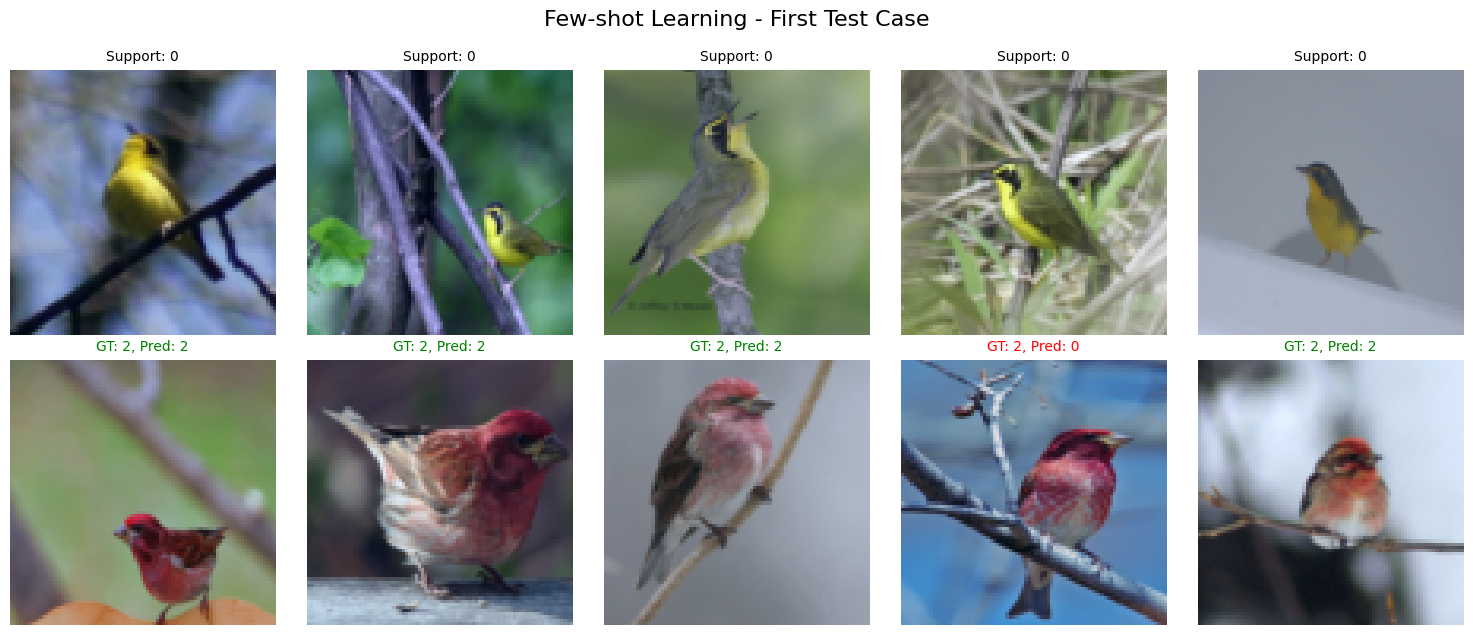

In [38]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# **取得測試任務（只取第一組）**
test_batch = next(iter(test_loader))

group_size = 5
N = 2  # 第 N 組，從 0 開始（N=2 代表第 3 組）

support_images, support_labels = test_batch[0][N*group_size : (N+1)*group_size], test_batch[1][N*group_size : (N+1)*group_size]
query_images, query_labels = test_batch[2][N*group_size : (N+1)*group_size], test_batch[3][N*group_size : (N+1)*group_size]

# # **解包第一組**
# support_images, support_labels = test_batch[0][:5], test_batch[1][:5]  # 取支撐集前 5 張
# query_images, query_labels = test_batch[2][:5], test_batch[3][:5]  # 取查詢集前 5 張

# **將 Tensor 轉換為 NumPy 格式，並修正像素範圍**
support_images = support_images.cpu().numpy().transpose(0, 2, 3, 1)  # (Batch, H, W, C)
query_images = query_images.cpu().numpy().transpose(0, 2, 3, 1)

# **修正圖像範圍，確保數值落在 [0,1]**
support_images = np.clip((support_images - support_images.min()) / (support_images.max() - support_images.min()), 0, 1)
query_images = np.clip((query_images - query_images.min()) / (query_images.max() - query_images.min()), 0, 1)

# **轉換 Query Images 為 PyTorch Tensor**
query_images_tensor = torch.tensor(query_images).permute(0, 3, 1, 2).to(DEVICE)

# **獲取模型預測**
model.set_use_fc(False)  # 確保模型不使用 FC 層
predictions = few_shot_classifier(query_images_tensor)  # 模型預測
predicted_labels = torch.argmax(predictions, dim=1).cpu().numpy()  # 取得預測類別

# **設定畫布大小**
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # 只顯示 5 張圖片

# **顯示支撐集（Support Set）**
for i in range(5):
    axes[0, i].imshow(support_images[i])
    axes[0, i].set_title(f"Support: {support_labels[i].item()}", fontsize=10)
    axes[0, i].axis("off")

# **顯示查詢集（Query Set），並標註真實 vs 預測類別**
for i in range(5):
    true_label = query_labels[i].item()
    pred_label = predicted_labels[i]
    title_color = "green" if true_label == pred_label else "red"  # 預測正確標題為綠色，錯誤則為紅色
    axes[1, i].imshow(query_images[i])
    axes[1, i].set_title(f"GT: {true_label}, Pred: {pred_label}", color=title_color, fontsize=10)
    axes[1, i].axis("off")

# **避免標題重疊**
plt.tight_layout()
plt.suptitle("Few-shot Learning - First Test Case", fontsize=16, y=1.05)
plt.show()


In [39]:
print("Support Labels:", support_labels.numpy())
print("Query Labels:", query_labels.numpy())


Support Labels: [0 0 0 0 0]
Query Labels: [2 2 2 2 2]


In [40]:
print("Unique Support Labels:", np.unique(support_labels.numpy()))

Unique Support Labels: [0]


In [41]:
print("Unique Query Labels:", np.unique(query_labels.numpy()))


Unique Query Labels: [2]


In [44]:
N_way = 3
support_indices = []
for class_id in range(N_way):
    indices = np.where(test_batch[1].numpy() == class_id)[0][:group_size]
    support_indices.extend(indices)
support_images, support_labels = test_batch[0][support_indices], test_batch[1][support_indices]
print(support_labels.numpy())

[0 0 0 0 0 1 1 1 1 1 2 2 2 2 2]


In [45]:
for i, test_batch in enumerate(test_loader):
    support_labels = np.unique(test_batch[1].numpy())  # 取得這個 batch 的支撐集標籤
    query_labels = np.unique(test_batch[3].numpy())  # 取得這個 batch 的查詢集標籤
    print(f"Batch {i}: Support Labels = {support_labels}, Query Labels = {query_labels}")
    if i == 5:  # 只查看前 5 個 batch
        break


Batch 0: Support Labels = [0 1 2], Query Labels = [0 1 2]
Batch 1: Support Labels = [0 1 2], Query Labels = [0 1 2]
Batch 2: Support Labels = [0 1 2], Query Labels = [0 1 2]
Batch 3: Support Labels = [0 1 2], Query Labels = [0 1 2]
Batch 4: Support Labels = [0 1 2], Query Labels = [0 1 2]
Batch 5: Support Labels = [0 1 2], Query Labels = [0 1 2]


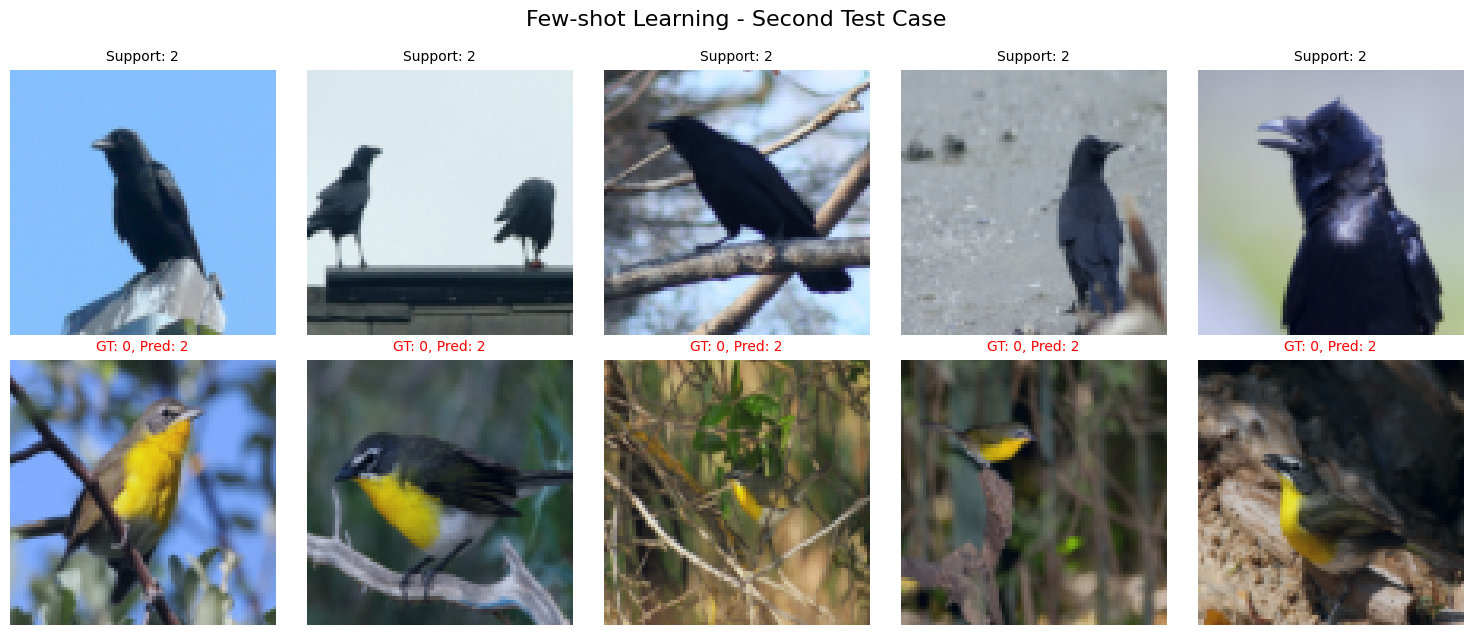

In [37]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# **取得測試任務（只取第二組）**
test_batch = next(iter(test_loader))

# **解包第二組（取索引範圍 5~9）**
support_images, support_labels = test_batch[0][5:10], test_batch[1][5:10]  # 支撐集
query_images, query_labels = test_batch[2][5:10], test_batch[3][5:10]  # 查詢集

# **將 Tensor 轉換為 NumPy 格式，並修正像素範圍**
support_images = support_images.cpu().numpy().transpose(0, 2, 3, 1)  # (Batch, H, W, C)
query_images = query_images.cpu().numpy().transpose(0, 2, 3, 1)

# **修正圖像範圍，確保數值落在 [0,1]**
support_images = np.clip((support_images - support_images.min()) / (support_images.max() - support_images.min()), 0, 1)
query_images = np.clip((query_images - query_images.min()) / (query_images.max() - query_images.min()), 0, 1)

# **轉換 Query Images 為 PyTorch Tensor**
query_images_tensor = torch.tensor(query_images).permute(0, 3, 1, 2).to(DEVICE)

# **獲取模型預測**
model.set_use_fc(False)  # 確保模型不使用 FC 層
predictions = few_shot_classifier(query_images_tensor)  # 模型預測
predicted_labels = torch.argmax(predictions, dim=1).cpu().numpy()  # 取得預測類別

# **設定畫布大小**
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # 只顯示 5 張圖片

# **顯示支撐集（Support Set）**
for i in range(5):
    axes[0, i].imshow(support_images[i])
    axes[0, i].set_title(f"Support: {support_labels[i].item()}", fontsize=10)
    axes[0, i].axis("off")

# **顯示查詢集（Query Set），並標註真實 vs 預測類別**
for i in range(5):
    true_label = query_labels[i].item()
    pred_label = predicted_labels[i]
    title_color = "green" if true_label == pred_label else "red"  # 預測正確標題為綠色，錯誤則為紅色
    axes[1, i].imshow(query_images[i])
    axes[1, i].set_title(f"GT: {true_label}, Pred: {pred_label}", color=title_color, fontsize=10)
    axes[1, i].axis("off")

# **避免標題重疊**
plt.tight_layout()
plt.suptitle("Few-shot Learning - Second Test Case", fontsize=16, y=1.05)
plt.show()
